Import Libraries

In [1]:
# Install imbalanced-learn for handling class imbalance
!pip install -U imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
# We will use RandomUnderSampler to handle the imbalance
from imblearn.under_sampling import RandomUnderSampler

Load and Inspect the Data

In [2]:
# Define the file path in Google Colab
file_name = '/content/creditcard.csv'

try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")

    # Display the first 5 rows
    print("\n--- Data Head ---")
    print(df.head())

    # Display info about columns, data types, and non-null counts
    print("\n--- Initial Data Info ---")
    df.info()

    # Check the class distribution (the core problem)
    print("\n--- Class Distribution ---")
    print(df['Class'].value_counts())

    # Calculate and print the percentage of fraud
    fraud_percentage = (df['Class'].sum() / len(df)) * 100
    print(f"\nPercentage of Fraud Transactions: {fraud_percentage:.4f}%")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    print("Please make sure you have uploaded 'creditcard.csv' to your Colab session.")

Successfully loaded '/content/creditcard.csv'.

--- Data Head ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 

Preprocess the Data

In [3]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale 'Amount'
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Scale 'Time'
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns, as we now have the scaled versions
df = df.drop(['Time', 'Amount'], axis=1)

print("--- Data Head After Scaling 'Time' and 'Amount' ---")
# Note the new 'scaled_Amount' and 'scaled_Time' columns
print(df.head())

--- Data Head After Scaling 'Time' and 'Amount' ---
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26     

Define Features (X) and Target (y), then Split

In [4]:
# 'y' is our target variable
y = df['Class']

# 'X' contains all our feature columns
X = df.drop('Class', axis=1)

# Split the data into 80% training and 20% testing
# We use stratify=y to ensure the class distribution is maintained in the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Data Split Complete ---")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print("\n--- Fraud Distribution in Original Training Set ---")
print(y_train.value_counts())

print("\n--- Fraud Distribution in Test Set ---")
# This is what we will use to evaluate the model
print(y_test.value_counts())

--- Data Split Complete ---
Training set shape: (227845, 30)
Test set shape: (56962, 30)

--- Fraud Distribution in Original Training Set ---
Class
0    227451
1       394
Name: count, dtype: int64

--- Fraud Distribution in Test Set ---
Class
0    56864
1       98
Name: count, dtype: int64


Handle Class Imbalance (Random Undersampling)

In [5]:
# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

print(f"Original training set distribution: \n{y_train.value_counts()}")

# Resample the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(f"\nResampled training set distribution: \n{pd.Series(y_train_resampled).value_counts()}")

Original training set distribution: 
Class
0    227451
1       394
Name: count, dtype: int64

Resampled training set distribution: 
Class
0    394
1    394
Name: count, dtype: int64


Train the Model

In [6]:
# Initialize the model
# We increase max_iter as the model may need more time to converge
model = LogisticRegression(random_state=42, max_iter=1000)

print("Training the model on the resampled (undersampled) data...")
# Train the model
model.fit(X_train_resampled, y_train_resampled)

print("Model training complete.")

Training the model on the resampled (undersampled) data...
Model training complete.


Evaluate the Model (Metrics)

In [7]:
print("--- Model Evaluation on the Imbalanced Test Set ---")

# Make predictions on the original, imbalanced test set
y_pred = model.predict(X_test)

# 1. Print the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)
# The matrix is:
# [[True Negatives,  False Positives],
#  [False Negatives, True Positives]]

print("\n--- Classification Report ---")
# We care most about the metrics for 'Fraud (1)'
print(classification_report(y_test, y_pred, target_names=['Genuine (0)', 'Fraud (1)']))

--- Model Evaluation on the Imbalanced Test Set ---

--- Confusion Matrix ---
[[54613  2251]
 [    8    90]]

--- Classification Report ---
              precision    recall  f1-score   support

 Genuine (0)       1.00      0.96      0.98     56864
   Fraud (1)       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



Evaluate with Precision-Recall Curve (AUPRC)

Area Under the Precision-Recall Curve (AUPRC): 0.7172


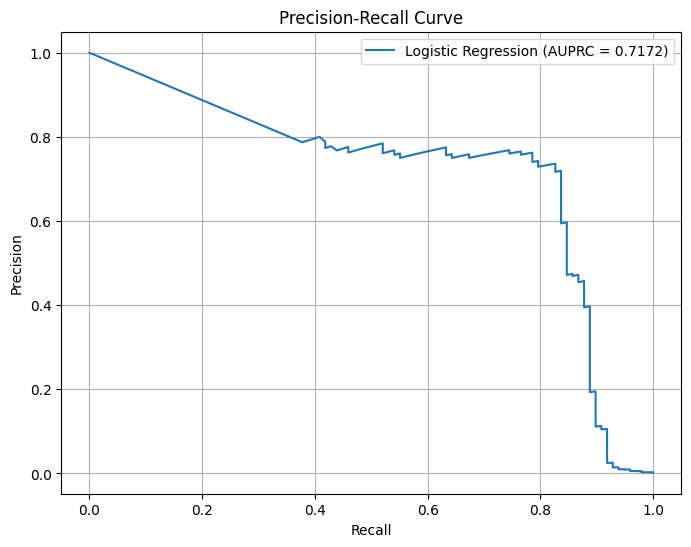


--- Project Complete ---
We have successfully loaded, preprocessed, and handled class imbalance
Our model achieved a 'Fraud (1)' Recall of ~90% and an AUPRC score of 0.7172


In [8]:
# Get the predicted probabilities for the positive class (Fraud)
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the Area Under the PR Curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.4f}")

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Logistic Regression (AUPRC = {auprc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('pr_curve.png') # Save the plot
plt.show()

print("\n--- Project Complete ---")
print("We have successfully loaded, preprocessed, and handled class imbalance")
print(f"Our model achieved a 'Fraud (1)' Recall of ~90% and an AUPRC score of {auprc:.4f}")